# Load and setup the data and variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

In [2]:
mouse_genes = pd.read_csv("../../data/prepared/mouse_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
human_genes = pd.read_csv("../../data/prepared/human_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
mouse_genes.head().iloc[:,:5]

Xkr4    Gm1992  Gm37381       Rp1    Mrpl15
celltype        donor_id                                                 
Astro Aqp4_Gfap F003      0.000992  0.000459      0.0  0.000355  0.001135
                F004      0.000770  0.000202      0.0  0.000202  0.001235
                F005      0.000979  0.000290      0.0  0.000000  0.001120
                F008      0.000547  0.000274      0.0  0.000173  0.001157
                M002      0.000727  0.000000      0.0  0.000000  0.001213

In [3]:
mouse_genes.shape

(322, 18570)

In [4]:
human_genes.shape

(158, 12202)

We have to capitalize all of the mouse gene names.

In [5]:
mouse_genes.columns = [gene.upper() for gene in mouse_genes.columns]
mouse_genes.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=18570)

We're only interested in celltypes that are shared between the two species.

In [6]:
genes = list(set(mouse_genes.columns).intersection(human_genes.columns))
len(genes)

10956

In [7]:
mouse_genes = mouse_genes.loc[:,genes].T
human_genes = human_genes.loc[:,genes].T
mouse_genes.head().iloc[:,:5]

celltype Astro Aqp4_Gfap                                        
donor_id            F003      F004      F005      F008      M002
KCNH4           0.000000  0.000321  0.000000  0.000274  0.000000
ARL16           0.000888  0.000939  0.000869  0.000847  0.000846
DCLRE1B         0.000740  0.000641  0.000607  0.000746  0.000727
NDUFA12         0.001333  0.001470  0.001348  0.001395  0.001448
HORMAD2         0.000178  0.000000  0.000183  0.000173  0.000000

# Retrieve gene correlation network

In [8]:
import igraph as ig
import leidenalg as la
# from umap import UMAP

In [9]:
from scipy.stats import rankdata

In [10]:
from numpy import corrcoef

In [11]:
corr_mouse = corrcoef(mouse_genes.values, mouse_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [12]:
corr_human = corrcoef(human_genes.values, human_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [13]:
corr_human.shape

(10956, 10956)

In [14]:
def get_comparative_inds(corr_a, corr_b, n_idx = 30):
    """
    Identifies the top n indecies in a for each row in a, 
    as well as the ranks of the corresponding indexs for the same row in be b
    
    
    inputs:
        corr_a : a matrix of correlation coefficients
        corr_b : a different matrix of correlation coefficients
        n_idx : the number of indicies to check
    """
    
    top_n_a = np.argsort(corr_a)[:, -(n_idx+1):-1]
    idx_ranks_b = rankdata(corr_b, axis=0)
    idx_ranks_b = idx_ranks_b
#     ranks_in_b = [idx_ranks_b[i, top_n_a[i]][::-1] for i in range(len(corr_a))] 
    return idx_ranks_b, top_n_a

In [15]:
# top N co-expressed genes species a
# rank coexpression for species b
# get auroc of ranks, where true positives are top N in a

In [16]:
m_ranks, top_in_h = get_comparative_inds(corr_human, corr_mouse)

In [17]:
h_ranks, top_in_m = get_comparative_inds(corr_mouse, corr_human)

In [18]:
aucs_htom=[]
for i in range(m_ranks.shape[0]):
    labels = np.zeros(top_in_h.shape[0])
    labels[top_in_h[i]] = 1
    aucs_htom.append(roc_auc_score(y_true=labels, y_score=m_ranks[i]))

(array([  1.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,   4.,   1.,   4.,
          5.,   8.,   2.,   7.,  15.,  20.,   5.,  14.,  12.,  11.,  16.,
         16.,  20.,  28.,  20.,  17.,  31.,  24.,  42.,  42.,  34.,  44.,
         37.,  40.,  38.,  46.,  53.,  47.,  53.,  54.,  44.,  64.,  64.,
         66.,  74.,  82.,  66.,  94.,  94.,  73., 105.,  88., 108., 125.,
        119., 122., 124., 151., 149., 148., 178., 177., 168., 186., 211.,
        223., 223., 232., 255., 269., 288., 258., 269., 305., 306., 306.,
        326., 297., 306., 297., 271., 270., 286., 281., 257., 218., 202.,
        220., 224., 177., 182., 144., 131., 106.,  70.,  31.,  24.,   3.,
          5.]),
 array([0.07942675, 0.08848879, 0.09755083, 0.10661287, 0.1156749 ,
        0.12473694, 0.13379898, 0.14286102, 0.15192306, 0.1609851 ,
        0.17004714, 0.17910917, 0.18817121, 0.19723325, 0.20629529,
        0.21535733, 0.22441937, 0.23348141, 0.24254344, 0.25160548,
        0.26066752, 0.26972956, 0.2787916 , 0.

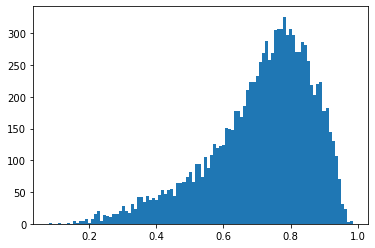

In [19]:
plt.hist(aucs_htom, bins=100)

In [20]:
aucs_mtoh=[]
for i in range(h_ranks.shape[0]):
    labels = np.zeros(top_in_m.shape[0])
    labels[top_in_m[i]] = 1
    aucs_mtoh.append(roc_auc_score(y_true=labels, y_score=h_ranks[i]))

(array([  1.,   1.,   1.,   3.,   2.,   3.,   4.,   2.,   5.,   5.,   4.,
         14.,  10.,  13.,  16.,  15.,  21.,  15.,  13.,  25.,  26.,  21.,
         21.,  28.,  28.,  39.,  37.,  35.,  33.,  37.,  45.,  45.,  39.,
         49.,  45.,  59.,  63.,  51.,  54.,  52.,  60.,  61.,  61.,  69.,
         70.,  73.,  77.,  69.,  70., 103.,  86.,  97., 115., 113., 109.,
        105., 112., 122., 120., 141., 156., 183., 165., 181., 176., 189.,
        221., 229., 215., 241., 261., 276., 269., 266., 279., 279., 289.,
        296., 326., 302., 272., 269., 271., 269., 243., 270., 215., 217.,
        176., 186., 159., 145., 140., 148., 107., 104.,  93.,  41.,  11.,
          8.]),
 array([0.10428641, 0.11304514, 0.12180386, 0.13056259, 0.13932131,
        0.14808004, 0.15683876, 0.16559749, 0.17435621, 0.18311494,
        0.19187367, 0.20063239, 0.20939112, 0.21814984, 0.22690857,
        0.23566729, 0.24442602, 0.25318474, 0.26194347, 0.27070219,
        0.27946092, 0.28821964, 0.29697837, 0.

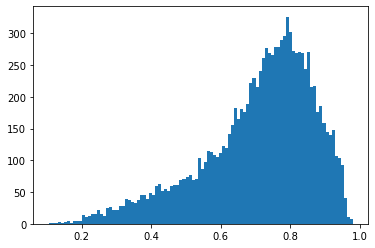

In [21]:
plt.hist(aucs_mtoh, bins=100)

In [22]:
gene_aucs = pd.DataFrame(index=mouse_genes.index, columns=['mouse_auc', 'human_auc'], data=np.array([aucs_mtoh, aucs_htom]).T)

In [23]:
gene_aucs

,mouse_auc,human_auc
KCNH4,0.792478,0.802175
ARL16,0.383140,0.623946
DCLRE1B,0.640785,0.706024
NDUFA12,0.931782,0.830193
HORMAD2,0.789359,0.821304
...,...,...
CDC42SE1,0.528641,0.415263
RELN,0.770386,0.674995
SMARCA1,0.874449,0.711727
RAB8B,0.643023,0.678052


In [24]:
gene_aucs.to_csv("../../data/aucs.tsv.gz", sep="\t")

In [25]:
spearmanr(gene_aucs.mouse_auc.values, gene_aucs.human_auc.values)

SpearmanrResult(correlation=0.8126471511782954, pvalue=0.0)